<a href="https://colab.research.google.com/github/CedricFont/Deep-learning-for-autonomous-vehicle/blob/develop/Final_project/Tests_for_pose_estimation/LSE_OpenPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

## Detect poses on a test video

We are going to detect poses on the following youtube video:

Download the above youtube video, remove the first 15 seconds and do the pose detection on the next 5 seconds:

In [5]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from google.colab.patches import cv2_imshow
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!pip install --upgrade gupload

from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

     |████████████████████████████████| 56 kB 3.4 MB/s 
     |████████████████████████████████| 81 kB 7.1 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.303 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.7.10 which is incompatible.


In [21]:
!ls -a
%cd ..
!ls -a
%cd content/drive/MyDrive/Colab_Notebooks
!ls -a

.     content	  etc	 lib64	proc	    sbin	       tmp
..    datalab	  home	 media	python-apt  srv		       tools
bin   dev	  lib	 mnt	root	    sys		       usr
boot  .dockerenv  lib32  opt	run	    tensorflow-1.15.2  var
/
.     content	  etc	 lib64	proc	    sbin	       tmp
..    datalab	  home	 media	python-apt  srv		       tools
bin   dev	  lib	 mnt	root	    sys		       usr
boot  .dockerenv  lib32  opt	run	    tensorflow-1.15.2  var
/content/drive/MyDrive/Colab_Notebooks
11_Panda_robot_identification.ipynb
CNN_pytorch_3_2_10_epochs.ckpt
CNN_pytorch_3_2.ckpt
CNN_pytorch.ckpt
getModels.sh
graph_opt.pb
image.jpg
linearClassifier_pytorch.ckpt
pose_deploy_linevec_faster_4_stages.prototxt
pose_deploy_linevec.prototxt
pose_iter_160000.caffemodel
Softmax.ipynb
softmax_weights.pkl
Untitled0.ipynb
Untitled1.ipynb


In [13]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [14]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

def preProcessImage(img):

  # Read image
  # frame = cv2.imread(img)
  frame = img

  # Specify the input image dimensions
  inWidth = 362
  inHeight = 362

  # Prepare the frame to be fed to the network
  inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

  cv2.imwrite('content/drive/Mydrive/Colab_Notebooks/inpBlob.jpg', inpBlob)  

  return inpBlob

def createNet():
  !cd openpose && ./build/examples/openpose/openpose.bin --image_dir content/drive/Mydrive/Colab_Notebooks/inputImg --write_images content/drive/Mydrive/Colab_Notebooks/outputImg --write_images_format jpg

def denoteLimbs(output):

  img = cv2.imread('content/drive/Mydrive/Colab_Notebooks/outputImg.jpg') 
  frame = img
  frameCopy = np.copy(img)
  frameWidth = frame.shape[1]
  frameHeight = frame.shape[0]
  threshold = 0.5

  # Specify the input image dimensions
  H = output.shape[2]
  W = output.shape[3]

  # Empty list to store the detected keypoints
  points = []

  for i in range(nPoints):
      # confidence map of corresponding body's part.
      probMap = output[0, i, :, :]

      # Find global maxima of the probMap.
      minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
      
      # Scale the point to fit on the original image
      x = (frameWidth * point[0]) / W
      y = (frameHeight * point[1]) / H

      if prob > threshold : 
          cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
          cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
          cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

          # Add the point to the list if the probability is greater than the threshold
          points.append((int(x), int(y)))
      else :
          points.append(None)

  # Draw Skeleton
  for pair in POSE_PAIRS:
      partA = pair[0]
      partB = pair[1]

      if points[partA] and points[partB]:
          cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

  return frame

In [11]:
%%shell cd openpose && ./build/examples/openpose/openpose.bin --image_dir examples/media/ --write_json output_jsons/

UsageError: Cell magic `%%shellcd` not found.


<IPython.core.display.Javascript object>

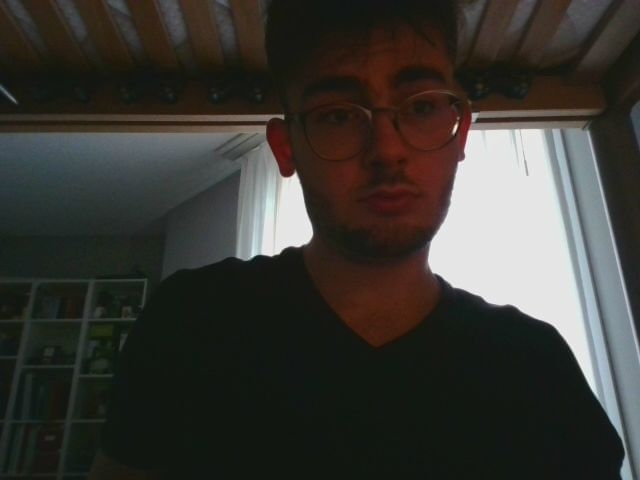

/bin/bash: line 0: cd: openpose: No such file or directory


AttributeError: ignored

In [31]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    inputImg = js_to_image(js_reply["img"])
    cv2_imshow(inputImg)
    _, JPEG = cv2.imencode('.jpeg', inputImg)
    cv2.imwrite('/content/drive/Colab_Notebooks/inputImg.jpg', JPEG) 
    createNet()
    outputImg = cv2.imread('content/drive/Mydrive/Colab_Notebooks/outputImg.jpg')

    cv2_imshow(outputImg)

In [ ]:
# !rm -rf youtube.mp4
# # download the youtube with the given ID
# !youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# # cut the seconds between 15 and 20
# !ffmpeg -y -loglevel info -i youtube.mp4 -ss 00:00:15.0 -t 5 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0 --write_video ../openpose.avi --face --hand
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

FileNotFoundError: ignored